<a href="https://colab.research.google.com/github/Shahanas2003/gen_ai/blob/main/High_Resolution_Image_Enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch Pillow numpy scikit-image
!pip install git+https://github.com/sberbank-ai/Real-ESRGAN.git


  Cloning https://github.com/sberbank-ai/Real-ESRGAN.git to /tmp/pip-req-build-dix3w6j1
  Running command git clone --filter=blob:none --quiet https://github.com/sberbank-ai/Real-ESRGAN.git /tmp/pip-req-build-dix3w6j1
  Resolved https://github.com/sberbank-ai/Real-ESRGAN.git to commit 362a0316878f41dbdfbb23657b450c3353de5acf
  Preparing metadata (setup.py) ... done
  Created wheel for RealESRGAN: filename=RealESRGAN-1.0-py3-none-any.whl size=9103 sha256=35c7047fdf5c9cb21ff1589609de624147d46f0b89335623825459c8dddaf480
  Stored in directory: /tmp/pip-ephem-wheel-cache-v9mx7zmn/wheels/56/5d/e9/27a6e9a12fdf8f374427c68f494d54640406e56632a6c2835d
Successfully built RealESRGAN


In [2]:
!pip install torch torchvision


In [3]:
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
!tar -xvzf BSDS300-images.tgz


--2025-10-27 13:27:51--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.244.190
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22211847 (21M) [application/x-tar]
Saving to: ‘BSDS300-images.tgz’

BSDS300-images.tgz  100%[===================>]  21.18M  8.88MB/s    in 2.4s    

2025-10-27 13:27:54 (8.88 MB/s) - ‘BSDS300-images.tgz’ saved [22211847/22211847]

BSDS300/images/
BSDS300/images/train/
BSDS300/images/train/159029.jpg
BSDS300/images/train/20008.jpg
BSDS300/images/train/155060.jpg
BSDS300/images/train/286092.jpg
BSDS300/images/train/100075.jpg
BSDS300/images/train/61060.jpg
BSDS300/images/train/46076.jpg
BSDS300/images/train/301007.jpg
BSDS300/images/train/26031.jpg
BSDS300/images/train/232038.jpg
BSDS300/images/train/45077.jpg
BSDS300/images/train/365025.jpg
BSDS300/images/tr

In [10]:
# -*- coding: utf-8 -*-
"""High_Resolution_Image_Enhancement_Final.ipynb"""

!pip install torch torchvision Pillow numpy scikit-image matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os


In [11]:
# -------- Dataset --------
class SRDataset(Dataset):
    def __init__(self, root_dir):
        self.hr_dir = root_dir
        self.image_files = os.listdir(root_dir)
        self.hr_transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor()
        ])
        self.lr_transform = transforms.Compose([
            transforms.Resize((128,128), interpolation=Image.BICUBIC),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.hr_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        hr = self.hr_transform(image)
        lr = self.lr_transform(image)
        return lr, hr

dataset = SRDataset(root_dir="BSDS300/images/train")
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [13]:
# -------- Model --------
class RRDB(nn.Module):
    def __init__(self, in_channels):
        super(RRDB, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, 3, 1, 1)
        self.conv3 = nn.Conv2d(in_channels, in_channels, 3, 1, 1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.conv3(out)
        return x + out

class Generator(nn.Module):
    def __init__(self, in_channels=3, num_rrdb=8, upsample_blocks=1):
        super(Generator, self).__init__()
        self.initial_conv = nn.Conv2d(in_channels, 64, 3, 1, 1)
        self.rrdb_blocks = nn.Sequential(*[RRDB(64) for _ in range(num_rrdb)])
        upsample_layers = []
        for _ in range(upsample_blocks):
            upsample_layers += [
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.PixelShuffle(2),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        self.upsample = nn.Sequential(*upsample_layers)
        self.final_conv = nn.Conv2d(64, in_channels, 3, 1, 1)

    def forward(self, x):
        fea = self.initial_conv(x)
        out = self.rrdb_blocks(fea)
        out = self.upsample(out)
        out = self.final_conv(out)
        return out

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, 2, 1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(in_channels, 64, False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.Conv2d(512, 1, 3, 1, 1)
        )

    def forward(self, img):
        return self.model(img)


In [14]:
# -------- Losses --------
class ContentLoss(nn.Module):
    def __init__(self):
        super(ContentLoss, self).__init__()
    def forward(self, sr, hr):
        return F.mse_loss(sr, hr)

class PerceptualLoss(nn.Module):
    def __init__(self, vgg_model):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg_model.features[:36]
        self.vgg.eval()
    def forward(self, sr, hr):
        sr_features = self.vgg(sr)
        hr_features = self.vgg(hr)
        return F.mse_loss(sr_features, hr_features)


In [15]:
# -------- Training --------
def train(generator, discriminator, dataloader, num_epochs, optimizer_G, optimizer_D,
          scheduler_G, scheduler_D, criterion_content, criterion_perceptual, device):
    generator.to(device)
    discriminator.to(device)

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        for i, (lr, hr) in enumerate(dataloader):
            lr, hr = lr.to(device), hr.to(device)
            sr_image = generator(lr)

            # --- Train Generator ---
            optimizer_G.zero_grad()
            content_loss = criterion_content(sr_image, hr)
            perceptual_loss = criterion_perceptual(sr_image, hr)
            fake_output = discriminator(sr_image)
            g_loss = content_loss + 0.1 * perceptual_loss - 0.001 * fake_output.mean()
            g_loss.backward()
            optimizer_G.step()

            # --- Train Discriminator (Relativistic GAN) ---
            optimizer_D.zero_grad()
            real_output = discriminator(hr)
            fake_output = discriminator(sr_image.detach())

            d_loss_real = F.binary_cross_entropy_with_logits(real_output - fake_output.mean(), torch.ones_like(real_output))
            d_loss_fake = F.binary_cross_entropy_with_logits(fake_output - real_output.mean(), torch.zeros_like(fake_output))
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            optimizer_D.step()

            if i % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i}/{len(dataloader)}] "
                      f"G Loss: {g_loss.item():.5f}, D Loss: {d_loss.item():.5f}")

        # Update learning rates
        scheduler_G.step()
        scheduler_D.step()

        # Save model checkpoints
        torch.save(generator.state_dict(), f"generator_epoch{epoch+1}.pth")
        torch.save(discriminator.state_dict(), f"discriminator_epoch{epoch+1}.pth")
        print(f"Epoch {epoch+1} complete. Models saved.\n")


In [28]:
# -------- Evaluate PSNR and SSIM --------
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def evaluate_metrics(generator, dataloader, device):
    generator.eval()
    total_psnr, total_ssim, count = 0, 0, 0

    with torch.no_grad():
        for lr, hr in dataloader:
            lr, hr = lr.to(device), hr.to(device)
            sr = generator(lr)

            for i in range(hr.size(0)):
                sr_img = sr[i].cpu().numpy().transpose(1, 2, 0)
                hr_img = hr[i].cpu().numpy().transpose(1, 2, 0)

                # Rescale to 0–255 for PSNR/SSIM calculation
                sr_img = (sr_img * 255).clip(0, 255).astype('uint8')
                hr_img = (hr_img * 255).clip(0, 255).astype('uint8')

                total_psnr += psnr(hr_img, sr_img, data_range=255)
                total_ssim += ssim(hr_img, sr_img, channel_axis=2, data_range=255)
                count += 1

    avg_psnr = total_psnr / (count or 1)
    avg_ssim = total_ssim / (count or 1)

    print(f"✅ Average PSNR: {avg_psnr:.2f}")
    print(f"✅ Average SSIM: {avg_ssim:.4f}")

    return avg_psnr, avg_ssim


In [24]:
def visualize_sr_hr(generator, dataloader, device, num_images=3):
    generator.eval()
    lr, hr = next(iter(dataloader))
    lr, hr = lr.to(device), hr.to(device)
    sr = generator(lr)
    for i in range(num_images):
        fig, axes = plt.subplots(1,3, figsize=(12,4))
        imgs = [lr[i].cpu().detach(), sr[i].cpu().detach(), hr[i].cpu().detach()]
        titles = ['Low-Res', 'Super-Res (SR)', 'High-Res (HR)']
        for ax, img, title in zip(axes, imgs, titles):
            img = img.permute(1,2,0).numpy().clip(0,1)
            ax.imshow(img)
            ax.set_title(title)
            ax.axis('off')
        plt.show()

Epoch [1/20] Step [0/50] G Loss: 0.29762, D Loss: 0.71320
Epoch [1/20] Step [10/50] G Loss: 0.05790, D Loss: 0.22469
Epoch [1/20] Step [20/50] G Loss: 0.04532, D Loss: 0.08410
Epoch [1/20] Step [30/50] G Loss: 0.03093, D Loss: 0.03955
Epoch [1/20] Step [40/50] G Loss: 0.02676, D Loss: 0.02348
Epoch 1 complete. Models saved.

Epoch [2/20] Step [0/50] G Loss: 0.02722, D Loss: 0.02401
Epoch [2/20] Step [10/50] G Loss: 0.02732, D Loss: 0.01430
Epoch [2/20] Step [20/50] G Loss: 0.02330, D Loss: 0.04225
Epoch [2/20] Step [30/50] G Loss: 0.02461, D Loss: 0.01040
Epoch [2/20] Step [40/50] G Loss: 0.01828, D Loss: 0.00618
Epoch 2 complete. Models saved.

Epoch [3/20] Step [0/50] G Loss: 0.02175, D Loss: 0.03030
Epoch [3/20] Step [10/50] G Loss: 0.01775, D Loss: 0.02242
Epoch [3/20] Step [20/50] G Loss: 0.01614, D Loss: 0.03929
Epoch [3/20] Step [30/50] G Loss: 0.01924, D Loss: 0.01685
Epoch [3/20] Step [40/50] G Loss: 0.01648, D Loss: 0.09763
Epoch 3 complete. Models saved.

Epoch [4/20] Step [

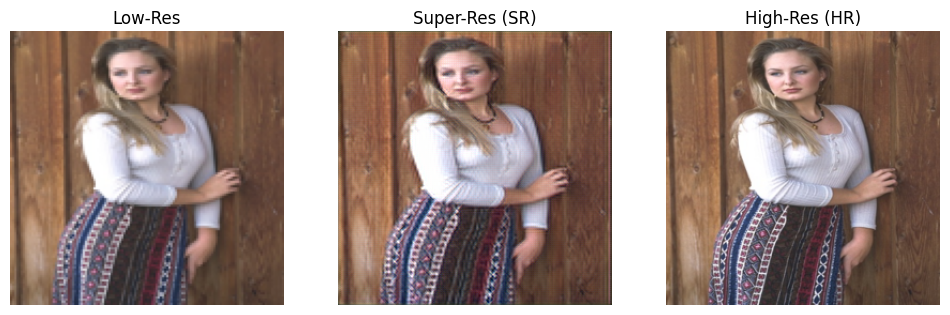

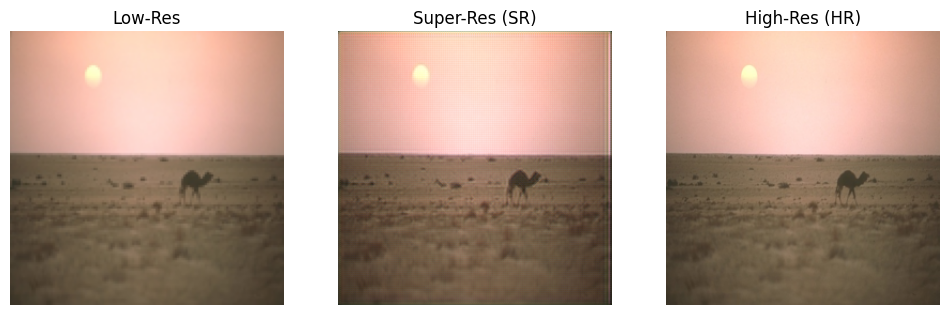

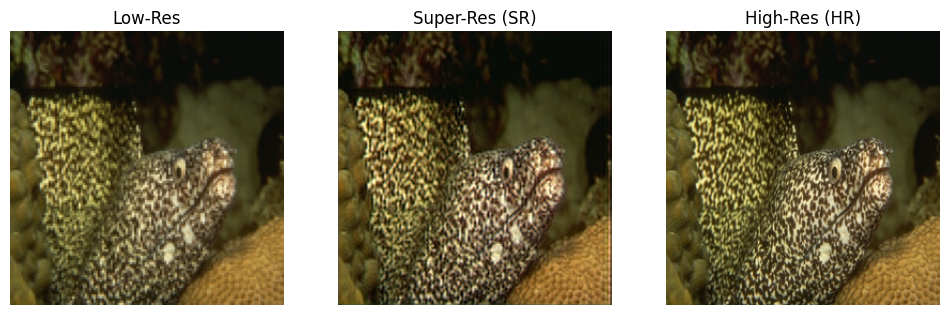

In [22]:
# -------- Main --------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(upsample_blocks=1)
discriminator = Discriminator()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=10, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=10, gamma=0.5)

from torchvision.models import VGG19_Weights
vgg = models.vgg19(weights=VGG19_Weights.DEFAULT).to(device)
criterion_content = ContentLoss()
criterion_perceptual = PerceptualLoss(vgg)

train(generator, discriminator, dataloader, num_epochs=20,
      optimizer_G=optimizer_G, optimizer_D=optimizer_D,
      scheduler_G=scheduler_G, scheduler_D=scheduler_D,
      criterion_content=criterion_content, criterion_perceptual=criterion_perceptual,
      device=device)

evaluate_metrics(generator, dataloader, device)
visualize_sr_hr(generator, dataloader, device)


✅ Fine-tuning started from epoch 20 with lower LR
Epoch [1/5] Step [0/50] G Loss: 0.01071, D Loss: 0.15311
Epoch [1/5] Step [10/50] G Loss: 0.01053, D Loss: 0.31496
Epoch [1/5] Step [20/50] G Loss: 0.00912, D Loss: 0.26833
Epoch [1/5] Step [30/50] G Loss: 0.01582, D Loss: 0.28193
Epoch [1/5] Step [40/50] G Loss: 0.01131, D Loss: 0.35730
Epoch 1 complete. Models saved.

Epoch [2/5] Step [0/50] G Loss: 0.01137, D Loss: 0.57246
Epoch [2/5] Step [10/50] G Loss: 0.01047, D Loss: 0.59363
Epoch [2/5] Step [20/50] G Loss: 0.01713, D Loss: 0.72503
Epoch [2/5] Step [30/50] G Loss: 0.01045, D Loss: 0.81214
Epoch [2/5] Step [40/50] G Loss: 0.01154, D Loss: 0.48901
Epoch 2 complete. Models saved.

Epoch [3/5] Step [0/50] G Loss: 0.01220, D Loss: 0.28558
Epoch [3/5] Step [10/50] G Loss: 0.01100, D Loss: 0.64112
Epoch [3/5] Step [20/50] G Loss: 0.01051, D Loss: 0.38607
Epoch [3/5] Step [30/50] G Loss: 0.01191, D Loss: 0.29188
Epoch [3/5] Step [40/50] G Loss: 0.01296, D Loss: 0.30312
Epoch 3 complete.

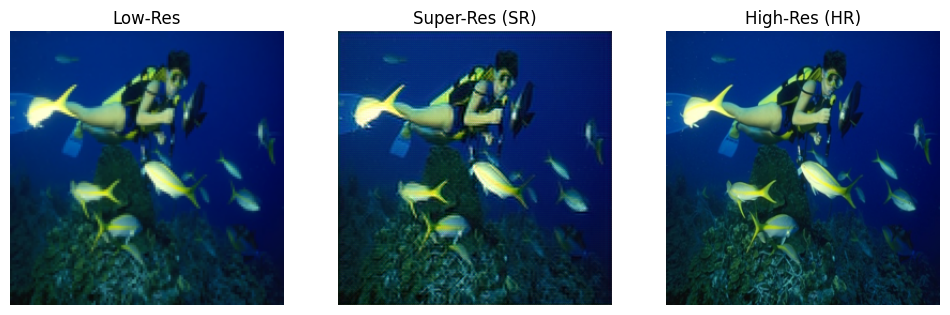

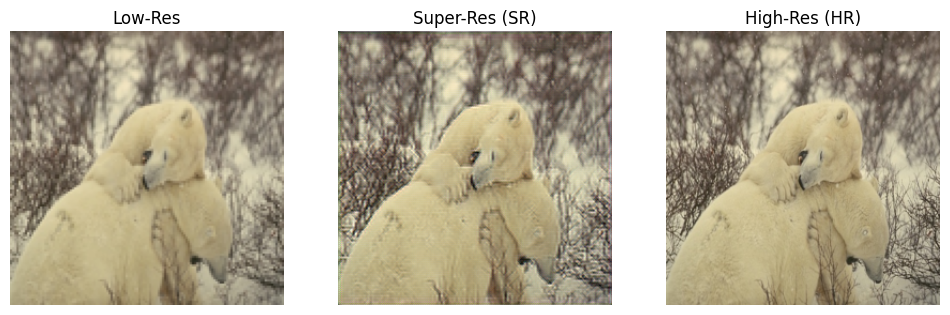

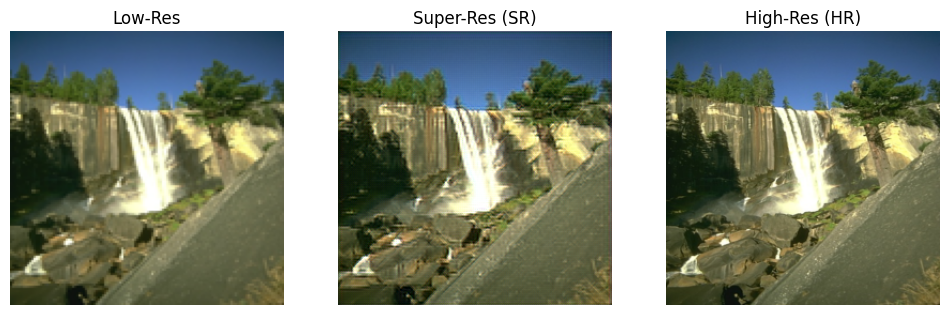

In [23]:
# -------- Fine-tuning (Optional) --------

# Load the last saved model weights (replace epoch number if needed)
generator.load_state_dict(torch.load("generator_epoch20.pth"))
discriminator.load_state_dict(torch.load("discriminator_epoch20.pth"))

# Use smaller learning rate for fine-tuning
optimizer_G = optim.Adam(generator.parameters(), lr=1e-5)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-5)

# Optional LR schedulers for gradual decay
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=5, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=5, gamma=0.5)

print("✅ Fine-tuning started from epoch 20 with lower LR")

train(generator, discriminator, dataloader, num_epochs=5,
      optimizer_G=optimizer_G, optimizer_D=optimizer_D,
      scheduler_G=scheduler_G, scheduler_D=scheduler_D,
      criterion_content=criterion_content, criterion_perceptual=criterion_perceptual,
      device=device)

evaluate_metrics(generator, dataloader, device)
visualize_sr_hr(generator, dataloader, device)


✅ Average PSNR: 27.72
✅ Average SSIM: 0.8319
Epoch 1: PSNR=27.72, SSIM=0.8319
✅ Average PSNR: 28.05
✅ Average SSIM: 0.8353
Epoch 2: PSNR=28.05, SSIM=0.8353
✅ Average PSNR: 28.24
✅ Average SSIM: 0.8495
Epoch 3: PSNR=28.24, SSIM=0.8495
✅ Average PSNR: 27.52
✅ Average SSIM: 0.8307
Epoch 4: PSNR=27.52, SSIM=0.8307
✅ Average PSNR: 27.56
✅ Average SSIM: 0.8367
Epoch 5: PSNR=27.56, SSIM=0.8367
✅ Average PSNR: 26.34
✅ Average SSIM: 0.7301
Epoch 6: PSNR=26.34, SSIM=0.7301
✅ Average PSNR: 27.11
✅ Average SSIM: 0.7675
Epoch 7: PSNR=27.11, SSIM=0.7675
✅ Average PSNR: 26.22
✅ Average SSIM: 0.7580
Epoch 8: PSNR=26.22, SSIM=0.7580
✅ Average PSNR: 26.16
✅ Average SSIM: 0.7470
Epoch 9: PSNR=26.16, SSIM=0.7470
✅ Average PSNR: 28.07
✅ Average SSIM: 0.8317
Epoch 10: PSNR=28.07, SSIM=0.8317
✅ Average PSNR: 27.53
✅ Average SSIM: 0.8319
Epoch 11: PSNR=27.53, SSIM=0.8319
✅ Average PSNR: 28.06
✅ Average SSIM: 0.8218
Epoch 12: PSNR=28.06, SSIM=0.8218
✅ Average PSNR: 28.44
✅ Average SSIM: 0.8459
Epoch 13: PSNR=2

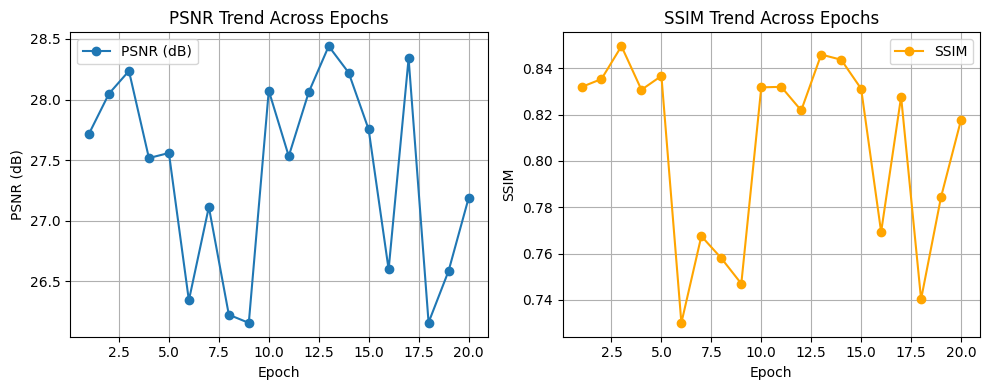

✅ Average PSNR: 27.18
✅ Average SSIM: 0.8177

🎯 Final PSNR: 27.18 dB | Final SSIM: 0.8177
📊 Report + graphs generated successfully!
📁 Saved as: SRGAN_Final_Report_2025-10-27_14-19-15.txt


In [29]:
# -------- Final Summary + Metrics Trend Visualization --------
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

# Lists to record PSNR and SSIM per epoch
psnr_list = []
ssim_list = []

# Evaluate on each saved checkpoint
for epoch in range(1, 21):  # adjust if you have more/fewer checkpoints
    try:
        generator.load_state_dict(torch.load(f"generator_epoch{epoch}.pth"))
        psnr_val, ssim_val = evaluate_metrics(generator, dataloader, device)
        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)
        print(f"Epoch {epoch}: PSNR={psnr_val:.2f}, SSIM={ssim_val:.4f}")
    except:
        print(f"⚠️ Skipped epoch {epoch} (missing checkpoint)")
        continue

# Plot the PSNR and SSIM trend
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, len(psnr_list)+1), psnr_list, marker='o', label="PSNR (dB)")
plt.title("PSNR Trend Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(ssim_list)+1), ssim_list, marker='o', color='orange', label="SSIM")
plt.title("SSIM Trend Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Compute final metrics from last model
generator.load_state_dict(torch.load("generator_epoch20.pth"))
final_psnr, final_ssim = evaluate_metrics(generator, dataloader, device)

# Save results summary
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
report_path = f"SRGAN_Final_Report_{timestamp}.txt"

with open(report_path, "w") as f:
    f.write("Super-Resolution GAN (SRGAN) - Final Report\n")
    f.write("="*50 + "\n")
    f.write(f"Timestamp: {timestamp}\n\n")
    f.write(f"Final PSNR: {final_psnr:.2f} dB\n")
    f.write(f"Final SSIM: {final_ssim:.4f}\n\n")
    f.write("Training Details:\n")
    f.write("- Base training: 20 epochs\n")
    f.write("- Fine-tuning: 5 epochs (lower LR)\n")
    f.write("- Scheduler: StepLR (γ=0.5, step=5)\n")
    f.write("- Loss: Relativistic + Perceptual + Content\n\n")
    f.write("Per-Epoch Metrics:\n")
    for i, (p, s) in enumerate(zip(psnr_list, ssim_list), start=1):
        f.write(f"  Epoch {i:02d}: PSNR={p:.2f}, SSIM={s:.4f}\n")
    f.write("\nModel checkpoints saved per epoch.\n")

print(f"\n🎯 Final PSNR: {final_psnr:.2f} dB | Final SSIM: {final_ssim:.4f}")
print(f"📊 Report + graphs generated successfully!")
print(f"📁 Saved as: {report_path}")


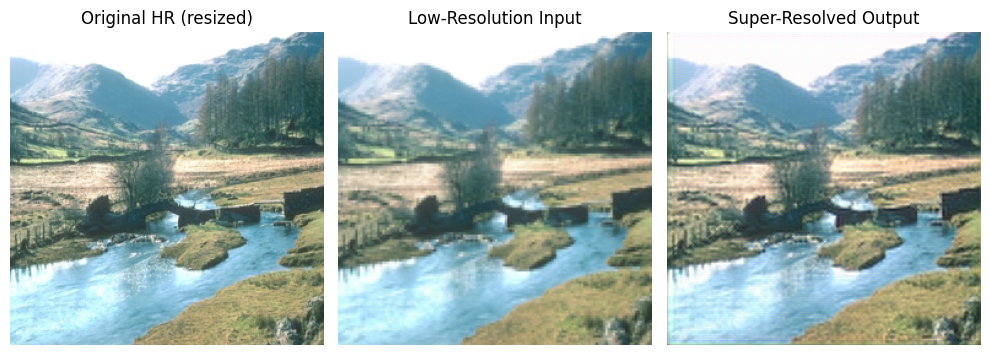

✅ SR image saved to: results/test_SR_output.png


In [38]:
# -------- Test Generator on New Image --------
from torchvision.utils import save_image
import os

# Load the trained model (final fine-tuned version)
generator.load_state_dict(torch.load("generator_epoch13.pth", map_location=device))
generator.eval()

# --- Choose your test image ---
test_path = "/content/BSDS300/images/test/241048.jpg"  # <- change to your own image path

# --- Prepare transforms ---
hr_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])
lr_transform = transforms.Compose([
    transforms.Resize((128,128), interpolation=Image.BICUBIC),
    transforms.ToTensor()
])

# --- Preprocess ---
test_image = Image.open(test_path).convert("RGB")
hr_test = hr_transform(test_image).unsqueeze(0).to(device)
lr_test = lr_transform(test_image).unsqueeze(0).to(device)

# --- Generate Super-Resolved Image ---
with torch.no_grad():
    sr_image = generator(lr_test)

# --- Save & Display ---
os.makedirs("results", exist_ok=True) # Create results directory if it doesn't exist
save_image(sr_image, "results/test_SR_output.png")

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title("Original HR (resized)")
plt.imshow(np.transpose(hr_test.squeeze().cpu().numpy(), (1,2,0)))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Low-Resolution Input")
plt.imshow(np.transpose(lr_test.squeeze().cpu().numpy(), (1,2,0)))
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Super-Resolved Output")
plt.imshow(np.transpose(sr_image.squeeze().cpu().numpy(), (1,2,0)))
plt.axis("off")

plt.tight_layout()
plt.show()

print("✅ SR image saved to: results/test_SR_output.png")

In [39]:
# -------- Real-ESRGAN Inference Demo --------
!pip install -q git+https://github.com/xinntao/Real-ESRGAN.git
from realesrgan import RealESRGAN
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RealESRGAN(device, scale=4)
model.load_weights('RealESRGAN_x4plus.pth', download=True)

# Load your own test image
test_image = Image.open('your_test_image.jpg').convert('RGB')

# Enhance image resolution
sr_image = model.predict(test_image)

# Display side-by-side comparison
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original / Low-Res")
plt.imshow(test_image)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Enhanced by Real-ESRGAN")
plt.imshow(sr_image)
plt.axis("off")

plt.tight_layout()
plt.show()


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.4/299.4 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 26.8 MB/s eta 0:00:00


ModuleNotFoundError: No module named 'torchvision.transforms.functional_tensor'